In [1]:
import numpy as np
import sklearn.datasets
import umap
import scipy.sparse
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
from sklearn.preprocessing import normalize

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ValueError(No function '__pyx_fuse_0pdtr' found in __pyx_capi__ of 'scipy.special.cython_special')'.
  numba.core.entrypoints.init_all()


In [2]:
digits = sklearn.datasets.load_digits()

In [3]:
mapper = umap.UMAP(n_neighbors=64).fit(digits.data)

In [4]:
graph = mapper.graph_.copy()

In [5]:
graph.diagonal()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [6]:
def laplacian_from_graph(graph):
    laplacian = -graph
    laplacian.setdiag(np.zeros(graph.shape[0]))
    laplacian.setdiag(-np.squeeze(np.asarray(laplacian.sum(axis=1))))
    return laplacian

In [7]:
def compute_omega(graph):
    laplacian = laplacian_from_graph(graph)
    laplacian_pinv = np.linalg.pinv(laplacian.toarray())
    omega = np.zeros(graph.data.shape[0])
    coo_graph = graph.tocoo()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        omega[n] = laplacian_pinv[i, i] + laplacian_pinv[j, j] - laplacian_pinv[i, j] - laplacian_pinv[j, i]
            
    omega_graph = coo_graph.copy()
    omega_graph.data = omega
    return omega, coo_graph, omega_graph.tocsr()

In [8]:
omega, coo_graph, omega_graph = compute_omega(graph)

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


/tmp/ipykernel_989/1166183605.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(omega)


<AxesSubplot:ylabel='Density'>

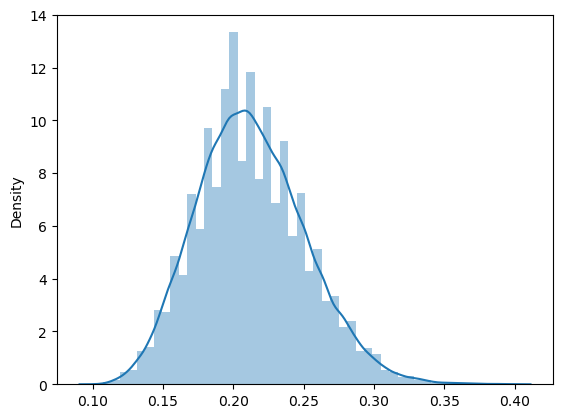

In [9]:
sns.distplot(omega)

In [10]:
omega_graph != omega_graph.transpose()

<1797x1797 sparse matrix of type '<class 'numpy.bool_'>'
	with 0 stored elements in Compressed Sparse Row format>

In [11]:
def compute_resistance_link_curvature(graph):
    omega, coo_graph = compute_omega(graph)
    relative_resistance = graph.copy()
    relative_resistance.data *= omega
    resistance_curvature = 1 - 0.5 * np.squeeze(np.asarray(relative_resistance.sum(axis=1)))
    resistance_link_curvature = coo_graph.copy()
    for n in range(coo_graph.data.shape[0]):
        i, j = coo_graph.row[n], coo_graph.col[n]
        if omega[n] > 0:
            resistance_link_curvature.data[n] = 2 * (resistance_curvature[i] + resistance_curvature[j]) / omega[n]
        else:
            resistance_link_curvature.data[n] = 0.0
        
    return resistance_link_curvature.tocsr()

In [12]:
def iterate_curvature_flow(graph, i):
    omega, next_graph, omega_graph = compute_omega(graph)
    print(omega, (omega_graph != omega_graph.transpose()).nnz)
    omega_scaling = (np.percentile(omega, 100 - 20 * np.power(2.0, -(i**2)/2)) - (omega))
#     omega_scaling /= omega_scaling.max()
    next_graph.data *= omega_scaling
#     next_graph -= 0.01 * omega_graph
#     next_graph.data /= omega
#     next_graph.data[omega_scaling < 0] = 0.0
#     next_graph = normalize(next_graph, norm="l1")
    next_graph.data[next_graph.data <0] = 0.0
    next_graph = normalize(next_graph, norm="l1")
    next_graph += next_graph.transpose()
    next_graph /= 2
#     next_graph = next_graph + next_graph.transpose() - next_graph.multiply(next_graph.transpose())
    next_graph.eliminate_zeros()
    return next_graph

In [13]:
%%time
for i in range(20):
    graph = iterate_curvature_flow(graph, i)

/home/lmmcinn/local/sandbox/leland/anaconda3/envs/tnt/lib/python3.10/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


[0.19140625 0.203125   0.1875     ... 0.25       0.23242188 0.25390625] 0
[2.1875  2.28125 2.03125 ... 4.5625  2.28125 2.625  ] 0
[3.      2.25    2.5     ... 3.      2.09375 3.0625 ] 0
[2.6875  2.5625  2.5     ... 4.03125 1.65625 3.6875 ] 0
[ 2.  2.  3. ... 16.  0.  0.] 0
[3.    2.5   2.625 ... 3.    1.25  3.875] 0
[3.       2.5      3.       ... 3.1875   1.25     3.953125] 0
[2.75    2.25    2.75    ... 3.25    1.21875 4.0625 ] 2
[3.     2.1875 2.625  ... 3.1875 1.25   4.25  ] 2
[2.75   2.375  2.375  ... 3.375  1.1875 4.125 ] 0
[3.     2.5    2.5    ... 3.375  1.1875 4.25  ] 0
[2.625 2.    2.5   ... 3.5   1.    4.5  ] 0
[2.75   2.5    3.     ... 3.3125 1.125  4.1875] 0
[3.         2.1875     2.5625     ... 3.27172852 1.13769531 4.28344727] 0
[3.   2.   2.5  ... 3.5  1.25 4.25] 0
[3.0625  2.125   2.6875  ... 3.53125 1.09375 4.21875] 0
[3.     2.     2.75   ... 3.5625 1.     4.125 ] 8
[3.     2.     2.5    ... 3.625  1.1875 4.125 ] 0
[3.      2.      2.5     ... 3.5625  1.15625 4.125  

In [14]:
graph

<1797x1797 sparse matrix of type '<class 'numpy.float32'>'
	with 91698 stored elements in Compressed Sparse Row format>

In [15]:
mapper.graph_

<1797x1797 sparse matrix of type '<class 'numpy.float32'>'
	with 145630 stored elements in Compressed Sparse Row format>

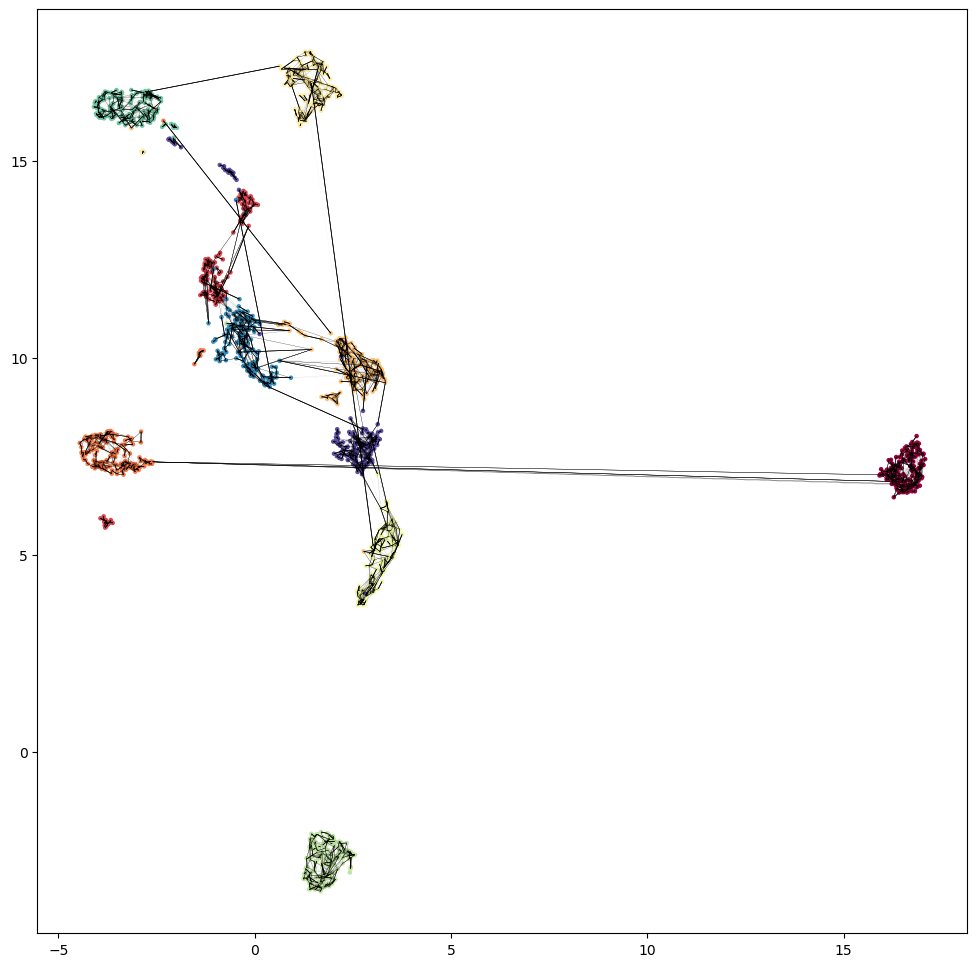

In [16]:
fig, ax = plt.subplots(figsize=(12,12))
coo_umap_graph = graph.tocoo()
edges = LineCollection(
    np.dstack([mapper.embedding_[coo_umap_graph.row], mapper.embedding_[coo_umap_graph.col]]).transpose((0, 2, 1)), 
    linewidths=np.clip(1e0 * coo_umap_graph.data, 0, 0.5),
    colors=np.vstack([np.zeros((3, coo_umap_graph.data.shape[0])), np.clip(1e1 * coo_umap_graph.data, 0, 1)]).T,
    zorder=3
)
ax.add_collection(edges)
ax.scatter(*mapper.embedding_.T, s=5, c=digits.target, cmap="Spectral", zorder=0)

In [17]:
coo_umap_graph.data

array([6.4573763e-04, 8.4642239e-02, 1.7098587e-03, ..., 1.4787642e-02,
       7.7902186e-01, 5.2365802e-02], dtype=float32)

In [18]:
np.bincount(scipy.sparse.csgraph.connected_components(graph)[1])

array([179, 834,   9, 175, 180, 167, 160,   3,   1,   2,   2,  11,  17,
         9,   3,  27,   3,   2,   1,   4,   3,   2,   2,   1])

In [19]:
import sklearn.metrics

In [20]:
sklearn.metrics.adjusted_rand_score(digits.target, scipy.sparse.csgraph.connected_components(graph)[1])

0.40422324283821903

In [21]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, scipy.sparse.csgraph.connected_components(graph)[1])

0.7422939080991605

In [22]:
import igraph as ig
import leidenalg

In [23]:
ig_graph = ig.Graph.Weighted_Adjacency(graph)

In [24]:
leiden_parts = list(leidenalg.find_partition(ig_graph, leidenalg.ModularityVertexPartition))
leiden_labels = np.full(graph.shape[0], -1, dtype=np.int32)
l = 0
for part in leiden_parts:
    if len(part) > 5:
        leiden_labels[part] = l
        l += 1

In [25]:
sklearn.metrics.adjusted_rand_score(digits.target, leiden_labels)

0.817571859303464

In [26]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, leiden_labels)

0.8717036035473383

In [27]:
leiden_labels.max()

15

In [28]:
ig_orig_graph = ig.Graph.Weighted_Adjacency(mapper.graph_)

In [29]:
leiden_parts = list(leidenalg.find_partition(ig_orig_graph, leidenalg.ModularityVertexPartition))
leiden_labels = np.full(graph.shape[0], -1, dtype=np.int32)
l = 0
for part in leiden_parts:
    if len(part) > 5:
        leiden_labels[part] = l
        l += 1

In [30]:
sklearn.metrics.adjusted_rand_score(digits.target, leiden_labels)

0.7125677367578962

In [31]:
sklearn.metrics.adjusted_mutual_info_score(digits.target, leiden_labels)

0.8016625976629065